In [1]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime
import time

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], Tru

Num GPUs Available:  1


In [3]:
# dimensions of our images.  
img_width, img_height = 224, 224  
   
top_model_weights_path = 'bottleneck_fc_model.h5'  
train_data_dir = 'data/train'  
validation_data_dir = 'data/validation' 
test_data_dir= 'data/test'
   
# number of epochs to train top model  
epochs = 100  
# batch size used by flow_from_directory and predict_generator  
batch_size = 36

In [4]:
from tensorflow.keras import applications
inc = applications.InceptionResNetV2(include_top=False, weights='imagenet') 

In [5]:
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck

In [6]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = inc.predict_generator(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 3852 images belonging to 4 classes.


c:\users\nishanth gowda\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Time:  0:00:39.214419


In [7]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


In [8]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = inc.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 3852 images belonging to 4 classes.
Time:  0:00:31.909453


In [9]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


In [10]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = inc.predict_generator(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 132 images belonging to 4 classes.
Time:  0:00:02.820032


In [6]:
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 


Found 3852 images belonging to 4 classes.


In [7]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  


Found 3852 images belonging to 4 classes.


In [8]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 132 images belonging to 4 classes.


In [9]:
from tensorflow.keras import optimizers

In [10]:
#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=7,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

c:\users\nishanth gowda\appdata\local\programs\python\python38\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/7
107/107 [==============================] - 3s 17ms/step - loss: 0.8708 - acc: 0.7736 - val_loss: 0.2303 - val_acc: 0.9187
Epoch 2/7
107/107 [==============================] - 1s 11ms/step - loss: 0.4564 - acc: 0.8697 - val_loss: 0.1481 - val_acc: 0.9491
Epoch 3/7
107/107 [==============================] - 1s 10ms/step - loss: 0.3737 - acc: 0.8962 - val_loss: 0.1221 - val_acc: 0.9574
Epoch 4/7
107/107 [==============================] - 1s 10ms/step - loss: 0.3467 - acc: 0.9058 - val_loss: 0.3497 - val_acc: 0.8795
Epoch 5/7
107/107 [==============================] - 1s 10ms/step - loss: 0.2572 - acc: 0.9278 - val_loss: 0.0716 - val_acc: 0.9727
Epoch 6/7
107/107 [==============================] - 1s 11ms/step - loss: 0.2500 - acc: 0.9338 - val_loss: 0.0659 - val_acc: 0.9746
Epoch 7/7
107/107 [==============================] - 1s 5ms/step - loss: 0.1157 - acc: 0.9613
[INFO] accuracy: 96.13%
[INFO] Loss: 0.11571837216615677
Time:  0:00:11.635272


In [11]:
#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 38400)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               3840100   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 204       
Total params: 3,845,354
Trainable params: 3,845,354
Non-trainable params: 0
______________________________________________

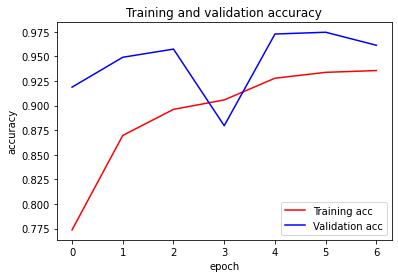

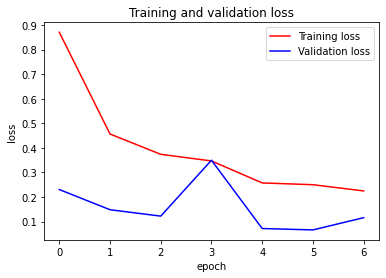

In [12]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [13]:
model.evaluate(test_data, test_labels)

5/5 [==============================] - 0s 8ms/step - loss: 0.2045 - acc: 0.9242


[0.20449870824813843, 0.9242424368858337]

In [14]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.25499654e-01
    6.82944655e-01 0.00000000e+00]
   [5.86296976e-01 4.61827010e-01 5.08192480e-01 ... 1.44897497e+00
    1.17924023e+00 0.00000000e+00]
   [0.00000000e+00 1.21522629e+00 8.12945724e-01 ... 1.66205037e+00
    1.12771285e+00 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 1.43686712e-01 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 5.22451639e-01 6.10143721e-01 ... 1.34317505e+00
    1.25251138e+00 0.00000000e+00]
   [0.00000000e+00 7.33275592e-01 1.80526897e-01 ... 1.25819373e+00
    8.98338437e-01 0.00000000e+00]
   [1.85014717e-02 7.17172503e-01 7.69410193e-01 ... 1.004242

In [15]:
animals = ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot','Corn_(maize)___Common_rust_','Corn_(maize)___healthy','Corn_(maize)___Northern_Leaf_Blight']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals )
print(classification_metrics)

                                                    precision    recall  f1-score   support

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       1.00      0.78      0.88        41
                       Corn_(maize)___Common_rust_       0.94      1.00      0.97        32
                            Corn_(maize)___healthy       0.80      0.97      0.88        33
               Corn_(maize)___Northern_Leaf_Blight       1.00      1.00      1.00        26

                                         micro avg       0.92      0.92      0.92       132
                                         macro avg       0.94      0.94      0.93       132
                                      weighted avg       0.94      0.92      0.92       132
                                       samples avg       0.92      0.92      0.92       132



In [16]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [17]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [18]:

#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


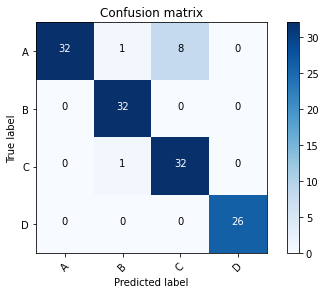

In [19]:
plot_confusion_matrix(confusion_matrix, ['A','B','C','D'])

Normalized confusion matrix


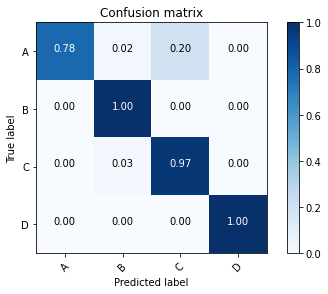

In [20]:
#Those numbers are all over the place. Now turning normalize= True
plot_confusion_matrix(confusion_matrix, 
                      ['A','B','C','D'],
                     normalize=True)


In [21]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [22]:
from keras.models import Sequential 

In [23]:
def test_single_image(path):
    animals =  ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot','Corn_(maize)___Common_rust_','Corn_(maize)___healthy','Corn_(maize)___Northern_Leaf_Blight']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = inc.predict(images)  
    preds = model.predict(bt_prediction)
    for idx, animal, x in zip(range(0,6), animals , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
#     class_predicted = model.predict_classes(bt_prediction)
#     class_dictionary = generator_top.class_indices  
#     inv_map = {v: k for k, v in class_dictionary.items()}  
#     print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
    return load_img(path)

In [24]:
path = 'data/test/Corn_(maize)___Common_rust_/RS_Rust 2741.jpg'

[INFO] loading and preprocessing image...
ID: 0, Label: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot 0.0%
ID: 1, Label: Corn_(maize)___Common_rust_ 100.0%
ID: 2, Label: Corn_(maize)___healthy 0.0%
ID: 3, Label: Corn_(maize)___Northern_Leaf_Blight 0.0%
Final Decision:
.
..
...


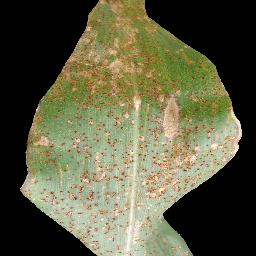

In [25]:
test_single_image(path)